<a href="https://colab.research.google.com/github/manish123k/Quora_Question_pair_similarity/blob/main/Quora_Question_pair_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3> Data Overview </h3>

<p>
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1>Exploratory Data Analysis </h1>

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences
from nltk.tokenize import word_tokenize
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


<h2> 3.1 Reading data and basic stats </h2>

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/major project/train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

<Axes: xlabel='is_duplicate'>

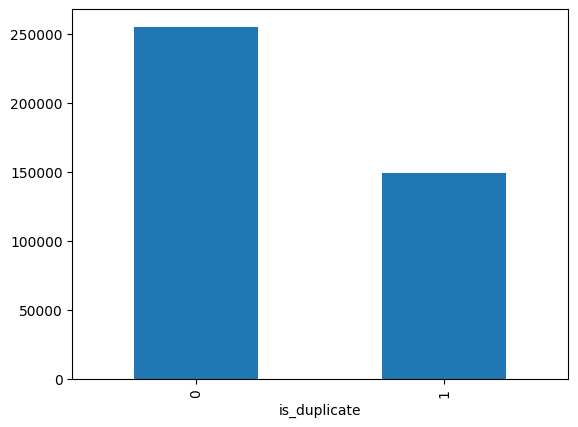

In [ ]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [ ]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [ ]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



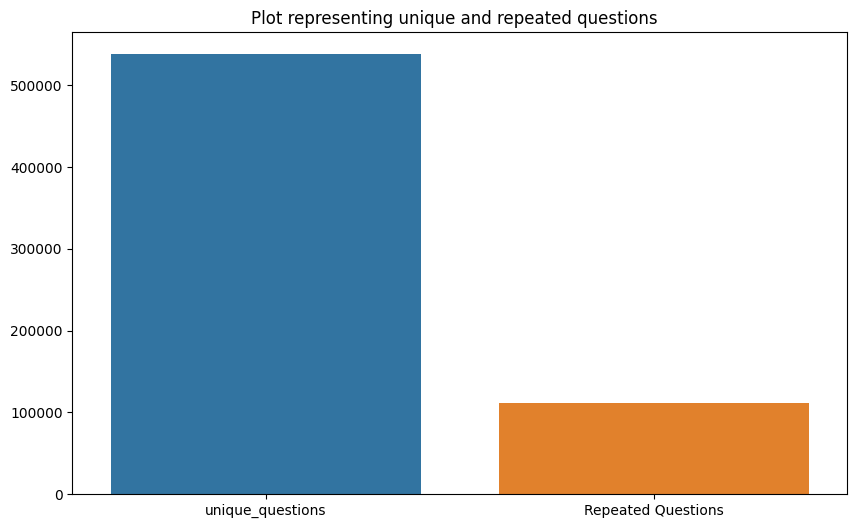

In [ ]:
plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x=["unique_questions" , "Repeated Questions"],y=[unique_qs , qs_morethan_onetime])
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [ ]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



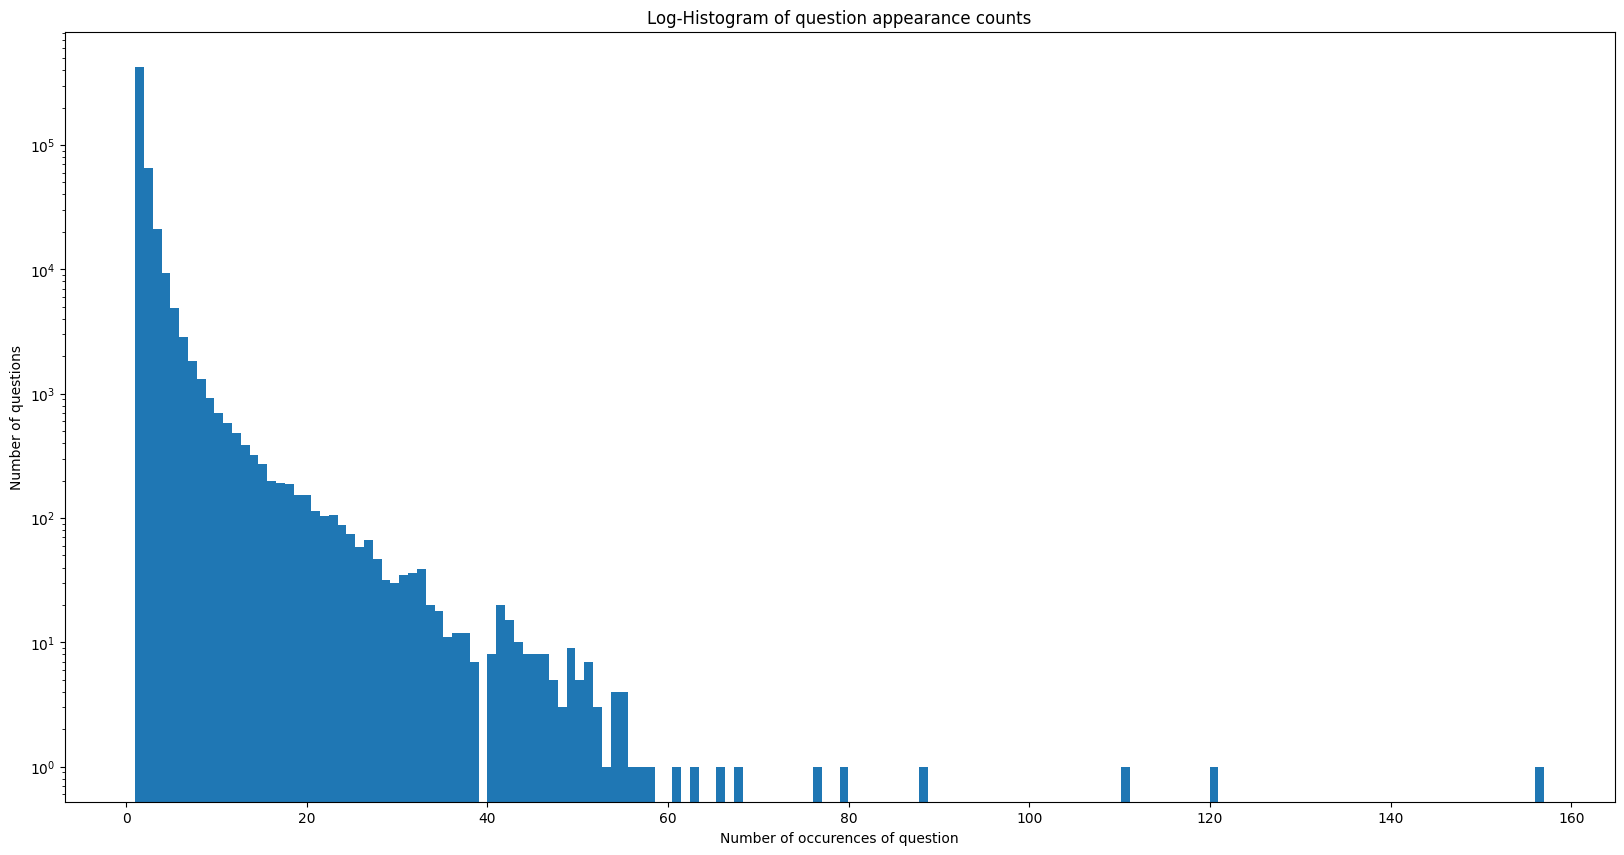

In [ ]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)
plt.yscale('log')
plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

<h3> 3.2.5 Checking for NULL values </h3>

In [ ]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


<ipython-input-13-ef527fb60746>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  nan_rows = df[df.isnull().any(1)]


- There are two rows with null values in question2

In [ ]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<ipython-input-14-f7ad6d675d3d>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  nan_rows = df[df.isnull().any(1)]


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def tokenize(s):
    tokens = word_tokenize(str(s))
    ans=[]
    for w in tokens:
      sm = re.sub('[^A-Za-z0-9]',' ', str(w))
      ans.append(sm)

    s1=' '.join(ans)
    s1=s1.split()
    s=' '.join(s1)
    return s.lower()

In [ ]:
tokenize("Find the remainder when [math]23^{24}[/math]")

'find the remainder when math 23 24 math'

In [ ]:
df["question1"]=df["question1"].apply(tokenize)

In [ ]:
df["question2"]=df["question2"].apply(tokenize)

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def my_stopword(data):
  c=[word for word in data.split() if word not in stopwords.words("english")]
  return " ".join(c)

In [ ]:
my_stopword("how many keywords are there in perl programmin")

'many keywords perl programmin'

In [ ]:
df["question1"]=df["question1"].apply(my_stopword)
df["question2"]=df["question2"].apply(my_stopword)

In [ ]:
df.to_csv("cleaned_data.csv")

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/major project/cleaned_data.csv")

In [ ]:
df.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,0
2,2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,3,3,7,8,mentally lonely solve,find remainder math 23 24 math divided 24 23,0
4,4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0


# Tokenizer

In [ ]:
MAX_NB_WORDS = 200000
tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(list(df['question1'].values.astype(str))+list(df['question2'].values.astype(str)))

# Padding and sequencing

In [ ]:
#for question1
X_train_q1 = tokenizer.texts_to_sequences(df['question1'].values.astype(str))
X_train_q1 = pad_sequences(X_train_q1, maxlen = 30, padding='post')

# for question2
X_train_q2 = tokenizer.texts_to_sequences(df['question2'].values.astype(str))
X_train_q2 = pad_sequences(X_train_q2, maxlen = 30, padding='post')

In [ ]:
df["seq1"]=list(X_train_q1)

In [ ]:
df["seq2"]=list(X_train_q2)

In [ ]:
df.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,seq1,seq2
0,0,0,1,2,step step guide invest share market india,step step guide invest share market,0,"[1105, 1105, 2438, 471, 648, 283, 3, 0, 0, 0, ...","[1105, 1105, 2438, 471, 648, 283, 0, 0, 0, 0, ..."
1,1,1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...,0,"[444, 14006, 13323, 20807, 4362, 0, 0, 0, 0, 0...","[7, 105, 26, 142, 11086, 14006, 13323, 20807, ..."
2,2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0,"[135, 337, 265, 1688, 75, 2638, 0, 0, 0, 0, 0,...","[265, 337, 3189, 1223, 10518, 0, 0, 0, 0, 0, 0..."
3,3,3,7,8,mentally lonely solve,find remainder math 23 24 math divided 24 23,0,"[2639, 2619, 540, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[29, 4018, 144, 2086, 1215, 144, 2317, 1215, 2..."
4,4,4,9,10,one dissolve water quikly sugar salt methane c...,fish would survive salt water,0,"[9, 6934, 145, 34126, 1763, 1906, 10353, 1792,...","[1804, 7, 1124, 1906, 145, 0, 0, 0, 0, 0, 0, 0..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    404290 non-null  int64 
 1   id            404290 non-null  int64 
 2   qid1          404290 non-null  int64 
 3   qid2          404290 non-null  int64 
 4   question1     404203 non-null  object
 5   question2     404213 non-null  object
 6   is_duplicate  404290 non-null  int64 
 7   seq1          404290 non-null  object
 8   seq2          404290 non-null  object
dtypes: int64(5), object(4)
memory usage: 27.8+ MB


In [ ]:
tokenizer.index_word

{1: 'best',
 2: 'get',
 3: 'india',
 4: 'people',
 5: 'like',
 6: 'good',
 7: 'would',
 8: 'n',
 9: 'one',
 10: 'quora',
 11: 'make',
 12: 'way',
 13: 'life',
 14: 'time',
 15: 'money',
 16: 'know',
 17: 'difference',
 18: 'learn',
 19: 'new',
 20: 'use',
 21: 'much',
 22: 'someone',
 23: 'think',
 24: 'many',
 25: 'work',
 26: 'indian',
 27: 'trump',
 28: 'ever',
 29: 'find',
 30: 'without',
 31: 'world',
 32: 'become',
 33: 'start',
 34: 'online',
 35: 'first',
 36: 'better',
 37: 'year',
 38: 'want',
 39: 'mean',
 40: '2',
 41: 'job',
 42: 'english',
 43: 'us',
 44: 'could',
 45: '1',
 46: 'feel',
 47: 'love',
 48: '2016',
 49: 'take',
 50: 'possible',
 51: 'day',
 52: '500',
 53: 'things',
 54: 'questions',
 55: 'go',
 56: 'notes',
 57: 'phone',
 58: '1000',
 59: 'buy',
 60: 'really',
 61: 'ways',
 62: 'person',
 63: 'engineering',
 64: 'account',
 65: 'weight',
 66: '3',
 67: 'used',
 68: 'donald',
 69: 'long',
 70: 'google',
 71: 'girl',
 72: 'old',
 73: 'number',
 74: 'improve',

In [ ]:
word_index = tokenizer.word_index

# Donload glove data from kaggle

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/rtatman/glove-global-vectors-for-word-representation?select=glove.6B.200d.txt")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: manish048kumar
Your Kaggle Key: ··········


100%|██████████| 458M/458M [00:05<00:00, 94.5MB/s]


# Glove word embedding

In [ ]:
embedding_index = {}
with open('./glove-global-vectors-for-word-representation/glove.6B.200d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:], 'float32')
        embedding_index[word] = vectors
    f.close()

In [ ]:
embedding_matrix = np.random.random((len(word_index)+1, 200))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# LSTM

In [ ]:
vocab_size=len(word_index)+1

In [ ]:
labels=df["is_duplicate"].values

In [ ]:
labels

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
text_input1=Input(shape=(None,),dtype='int32')
embedding1=Embedding(vocab_size,64)(text_input1)
encoded_text1=LSTM(32)(embedding1)

text_input2=Input(shape=(None,),dtype='int32')
embedding2=Embedding(vocab_size,64)(text_input2)
encoded_text2=LSTM(32)(embedding2)

concatenated=concatenate([encoded_text1,encoded_text2],axis=-1)

output=Dense(64,activation='relu')(concatenated)
output=Dense(1,activation='sigmoid')(output)

In [ ]:
model=Model([text_input1,text_input2],output)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, None, 64)     5450176     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, None, 64)     5450176     input_8[0][0]                    
____________________________________________________________________________________________

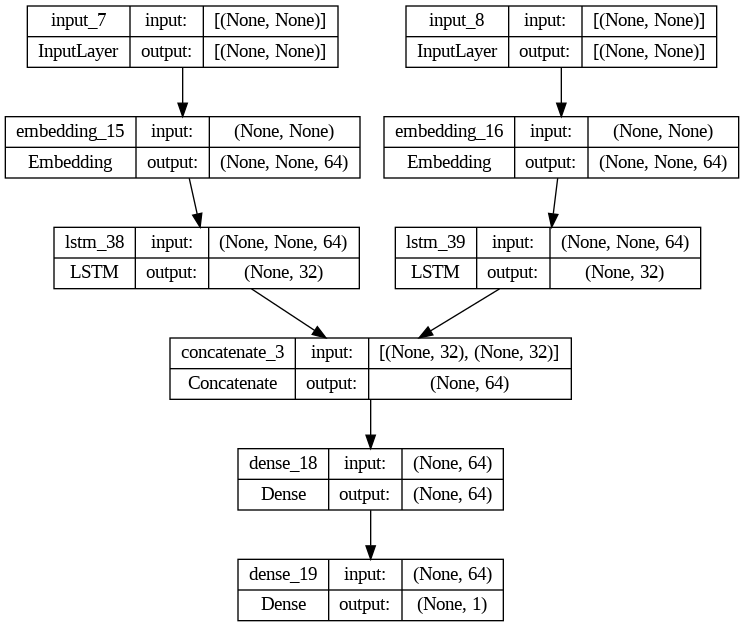

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
hist = model.fit([X_train_q1,X_train_q2],labels,epochs = 10,batch_size=128)

Epoch 1/10
3159/3159 [==============================] - 698s 219ms/step - loss: 0.5191 - accuracy: 0.7422
Epoch 2/10
3159/3159 [==============================] - 704s 223ms/step - loss: 0.4494 - accuracy: 0.7848
Epoch 3/10
3159/3159 [==============================] - 698s 221ms/step - loss: 0.4038 - accuracy: 0.8071
Epoch 4/10
3159/3159 [==============================] - 695s 220ms/step - loss: 0.3608 - accuracy: 0.8272
Epoch 5/10
3159/3159 [==============================] - 690s 218ms/step - loss: 0.3193 - accuracy: 0.8488
Epoch 6/10
3159/3159 [==============================] - 688s 218ms/step - loss: 0.2843 - accuracy: 0.8660
Epoch 7/10
3159/3159 [==============================] - 697s 220ms/step - loss: 0.2541 - accuracy: 0.8812
Epoch 8/10
3159/3159 [==============================] - 695s 220ms/step - loss: 0.2274 - accuracy: 0.8944
Epoch 9/10
 481/3159 [===>..........................] - ETA: 9:38 - loss: 0.1852 - accuracy: 0.9144